# Data Processing

In [13]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [14]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time as timer
import pickle

use_rho_time = 0
Input_File = 'ChangeDataset622v1.pickle'

def ReadPickle(filename: str) -> dict:
  '''Reads in data from given pickle files, outputs a dictionary'''
  try:
    Data = pd.read_pickle(filename)
  except FileNotFoundError:
    raise FileNotFoundError(f'Error reading {filename}')
  return Data

print(f"Loading Dataset -- '{Input_File}'")
t_Load1a = timer.time()
Data = ReadPickle(Input_File)
t_Load2a = timer.time()
print(f"Dataset took {round(t_Load2a-t_Load1a,2)}s to load")

D_data = np.array([np.tile(sample['Diffusion'],(1000,1)) for sample in Data])
V_data = np.array([np.tile(sample['Convection'],(1000,1)) for sample in Data])
if use_rho_time:
  R_data = np.array([np.tile(sample['Rho'],(1000,1)) for sample in Data])
  T_data = np.array([np.tile(sample['Time'],(50, 1)).T for sample in Data])
N_data = np.array([Sample['Density'] for Sample in Data])
S_data = np.array([Sample['Source'].T for Sample in Data])
if use_rho_time:
  Database = np.array([np.array([D_data[i],V_data[i],R_data[i],T_data[i],N_data[i],S_data[i]]) for i in range(len(Data))])
else:
  Database = np.array([np.array([D_data[i],V_data[i],N_data[i],S_data[i]]) for i in range(len(Data))])
print(Database.shape)

Loading Dataset -- 'ChangeDataset622v1.pickle'
Dataset took 1.74s to load
(1000, 4, 1000, 50)


In [18]:
#This i will code myself later, had gpt code up a basic scaler to use for testing now

#############################GPT CODE FOR SCALING##############################

import numpy as np

# Assume Database is loaded with shape (1000, 6, 1000, 50)
print("Original shape:", Database.shape)

# Prepare an empty array to hold the standardized data
Database_channel_standardized = np.empty_like(Database)

# Loop over each channel to standardize it independently.
# Here axis=(0, 2, 3) computes statistics across all samples and the 2D dimensions for the given channel.
num_channels = Database.shape[1]
for c in range(num_channels):
    channel_data = Database[:, c, :, :]
    channel_mean = np.mean(channel_data)
    channel_std = np.std(channel_data)
    print(f"Channel {c}: mean = {channel_mean:.4f}, std = {channel_std:.4f}")
    
    Database_channel_standardized[:, c, :, :] = (channel_data - channel_mean) / channel_std

# Optionally, verify the results for one channel:
print("\nChannel 3 after standardization: mean = {:.4f}, std = {:.4f}".format(
    np.mean(Database_channel_standardized[:, 3, :, :]),
    np.std(Database_channel_standardized[:, 3, :, :])
))

#############################GPT CODE FOR SCALING##############################

Original shape: (1000, 4, 1000, 50)
Channel 0: mean = 0.9139, std = 0.5197
Channel 1: mean = 0.1455, std = 0.9727
Channel 2: mean = 37587480760498192384.0000, std = 26376029163218866176.0000
Channel 3: mean = 7438569513106123776.0000, std = 16713426982899210240.0000

Channel 3 after standardization: mean = 0.0000, std = 1.0000


# Convolutional VAE 

In [19]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Convolutional Variational Autoencoder:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim=640):
        super(VariationalAutoencoder, self).__init__()
        
        # Encoder:
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=num_channels*2, kernel_size=3, stride=2, padding=1),# -> (12, 500, 25)
            nn.SELU(),
            nn.Conv2d(num_channels*2, num_channels*4, kernel_size=3, stride=2, padding=1),# -> (24, 250, 13)
            nn.SELU(),
            nn.Conv2d(num_channels*4, num_channels*8, kernel_size=3, stride=2, padding=1),# -> (48, 125, 7)
            nn.SELU(),
            nn.Conv2d(num_channels*8, num_channels*16, kernel_size=3, stride=2, padding=1),# -> (96, 63, 4)
            nn.SELU()
        )
        
        #Flattened conv feature size is 96*63*4 = 24192
        self.fc1 = nn.Linear(num_channels*16*63*4,128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        
        #Decoder:
        self.decoder_fc = nn.Linear(latent_dim, num_channels*16*63*4)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(num_channels*16, num_channels*8, kernel_size=3, stride=2, padding=1, output_padding=0),# -> (48, 125, 7)
            nn.SELU(),
            nn.ConvTranspose2d(num_channels*8, num_channels*4, kernel_size=3, stride=2, padding=1, output_padding=(1, 0)),# -> (24, 250, 13)
            nn.SELU(),
            nn.ConvTranspose2d(num_channels*4, num_channels*2, kernel_size=3, stride=2, padding=1, output_padding=(1, 0)),# -> (12, 500, 25)
            nn.SELU(),
            nn.ConvTranspose2d(num_channels*2, num_channels, kernel_size=3, stride=2, padding=1, output_padding=(1, 1))# -> (6, 1000, 50)
        )
    
    def encode(self, x):
        x = self.encoder_conv(x)
        x = x.view(x.size(0),-1)
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        x = self.decoder_fc(z)
        x = x.view(-1,num_channels*16,63,4)
        x = self.decoder_conv(x)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        decoded = self.decode(z)
        return decoded, mu, logvar

#Updated Loss Function using Mean Squared Error (MSE)
def vae_loss(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='mean')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

#Custom Dataset to handle the numerical array
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
        
    def __len__(self):
        return self.data.size(0)
    
    def __getitem__(self, idx):
        return self.data[idx], 0

# CNN Classifier

In [41]:
class CNNDiscriminator(nn.Module):
    def __init__(self):
        super(CNNDiscriminator, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(num_channels, 16, kernel_size=(15,3), stride=(10,2), padding=1),  # (16, 100, 25)
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 32, kernel_size=(15,3), stride=(10,2), padding=1),  # (32, 9, 13)
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*9*13, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()  # Binary classification (real vs fake)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return self.classifier(x)


## VAE-GAN

In [42]:
dataset = CustomDataset(Database_channel_standardized)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Hyperparameters
latent_dim = 640
batch_size = 32
lr_vae = 1e-4
num_epochs_pretraining = 50#50

#Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VariationalAutoencoder(latent_dim=latent_dim).to(device)
opt_G = optim.Adam(vae.parameters(), lr=lr_vae)

#Training Loop
for epoch in range(num_epochs_pretraining):
    epoch_loss = 0
    for batch_data, _ in dataloader:
        batch_data = batch_data.to(device)
        decoded_data, mu, logvar = vae(batch_data)
        
        loss = vae_loss(decoded_data, batch_data, mu, logvar)
        opt_G.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
        opt_G.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(dataset)
    print(f"Epoch [{epoch+1}/{num_epochs_pretraining}], Average Loss: {avg_loss:.4f}")
    
print("Training complete!")


Epoch [1/50], Average Loss: 1.2415


KeyboardInterrupt: 

In [ ]:
torch.save(vae, 'VAE_Pretrained_NoRT_v1.pt')

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

vae2 = torch.load('VAE_Pretrained_NoRT_v1.pt', weights_only=False)
num_epochs = 25
lr_disc = 4e-5
lr_vae2 = 1e-2
disc = CNNDiscriminator().to(device)
opt_D = optim.Adam(disc.parameters(), lr=lr_disc)
opt_G = optim.Adam(vae.parameters(), lr=lr_vae2)

# Loss functions
bce = nn.BCELoss()
mse_loss = nn.MSELoss(reduction='mean')

# Label funcs
def real_label(size):
    return torch.ones(size, 1, device=device)

def fake_label(size):
    return torch.zeros(size, 1, device=device)

# Training Loop
for epoch in range(1, num_epochs + 1):
    vae2.train()
    disc.train()

    total_G_loss = 0.0
    total_D_loss = 0.0

    for x_real, _ in dataloader:
        x_real = x_real.to(device)
        bs = x_real.size(0)

        # Discriminator update
        with torch.no_grad():
            z = torch.randn(bs, latent_dim, device=device)
            x_sample = vae2.decode(z) # Pure decoder samples
            bs, C, T, S = x_sample.shape

            # Time Average D & V
            time_mean = x_sample[:, 0:2, :, :].mean(dim=2, keepdim=True) 
            time_mean_expanded = time_mean.expand(bs, 2, T, S)
            x_sample[:, 0:2, :, :] = time_mean_expanded

        #Add Noise
        noise_real = 0.1*x_real.std(dim=[0,2,3], keepdim=True)*torch.randn_like(x_real)
        noise_fake = 0.1*x_sample.std(dim=[0,2,3], keepdim=True)*torch.randn_like(x_sample)

        x_real_noisy = x_real + noise_real
        x_sample_noisy = x_sample + noise_fake

        # 3) Discriminator forward
        d_out_real = disc(x_real_noisy)
        d_out_fake = disc(x_sample_noisy)

        loss_D_real = bce(d_out_real, real_label(bs))
        loss_D_fake = bce(d_out_fake, fake_label(bs))
        loss_D = 0.5*(loss_D_real + loss_D_fake)

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # Generator (VAE) update
        x_recon, mu, logvar = vae2(x_real)
        d_out_fake = disc(x_recon)

        # Reconstruction + KL
        recon_loss = mse_loss(x_recon, x_real)
        kl_loss = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Adversarial (fool discriminator)
        adv_loss = bce(d_out_fake, real_label(bs))

        # Weighted sum
        lambda_kl = 1e-4
        lambda_adv = 1e-4
        loss_G = recon_loss + lambda_kl*kl_loss + lambda_adv*adv_loss

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

        total_D_loss += loss_D.item()
        total_G_loss += loss_G.item()

    avg_D = total_D_loss/len(dataloader)
    avg_G = total_G_loss/len(dataloader)
    print(f"Epoch [{epoch}/{num_epochs}]  Loss_D: {avg_D:.4f}  Loss_G: {avg_G:.4f}")


Epoch [1/25]  Loss_D: 0.4938  Loss_G: 0.5441
Epoch [2/25]  Loss_D: 0.1967  Loss_G: 0.5473
Epoch [3/25]  Loss_D: 0.0764  Loss_G: 0.5454
Epoch [4/25]  Loss_D: 0.0395  Loss_G: 0.5537
Epoch [5/25]  Loss_D: 0.0249  Loss_G: 0.5450
Epoch [6/25]  Loss_D: 0.0173  Loss_G: 0.5404
Epoch [7/25]  Loss_D: 0.0127  Loss_G: 0.5455
Epoch [8/25]  Loss_D: 0.0098  Loss_G: 0.5449
Epoch [9/25]  Loss_D: 0.0076  Loss_G: 0.5428
Epoch [10/25]  Loss_D: 0.0063  Loss_G: 0.5431
Epoch [11/25]  Loss_D: 0.0050  Loss_G: 0.5434
Epoch [12/25]  Loss_D: 0.0042  Loss_G: 0.5406
Epoch [13/25]  Loss_D: 0.0037  Loss_G: 0.5465
Epoch [14/25]  Loss_D: 0.0032  Loss_G: 0.5428
Epoch [15/25]  Loss_D: 0.0028  Loss_G: 0.5438
Epoch [16/25]  Loss_D: 0.0024  Loss_G: 0.5446
Epoch [17/25]  Loss_D: 0.0020  Loss_G: 0.5481
Epoch [18/25]  Loss_D: 0.0019  Loss_G: 0.5452
Epoch [19/25]  Loss_D: 0.0017  Loss_G: 0.5409
Epoch [20/25]  Loss_D: 0.0013  Loss_G: 0.5420
Epoch [21/25]  Loss_D: 0.0006  Loss_G: 0.5387
Epoch [22/25]  Loss_D: 0.0004  Loss_G: 0.55

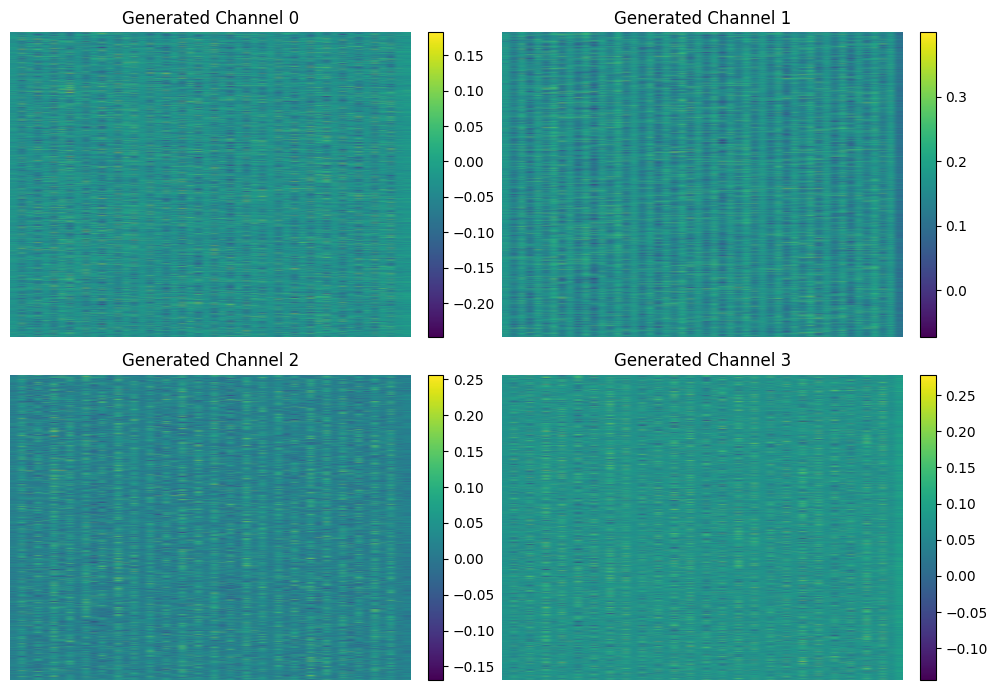

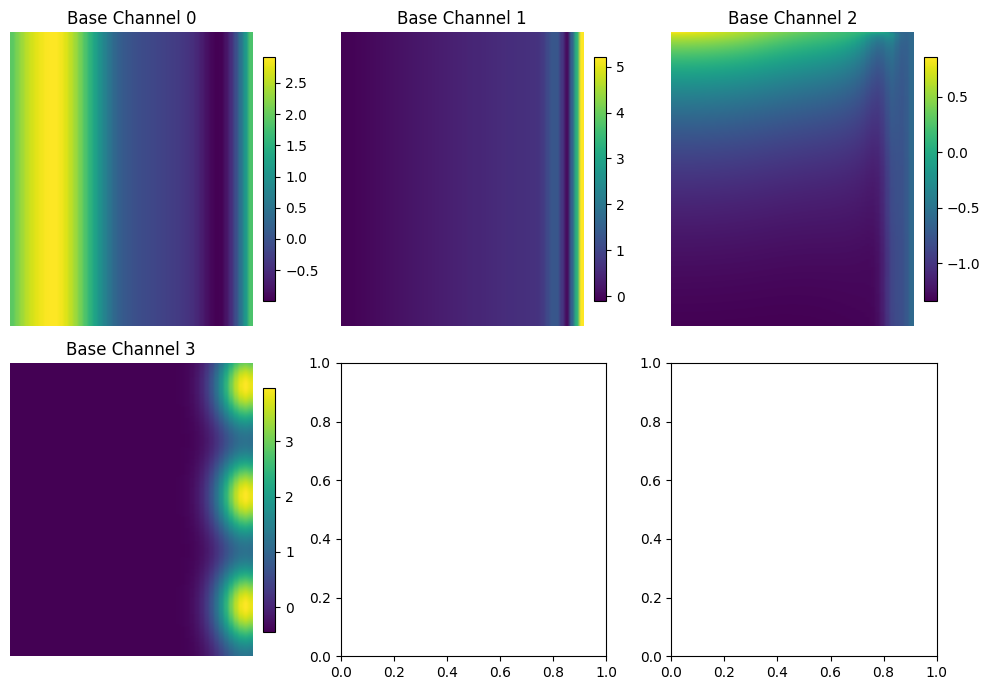

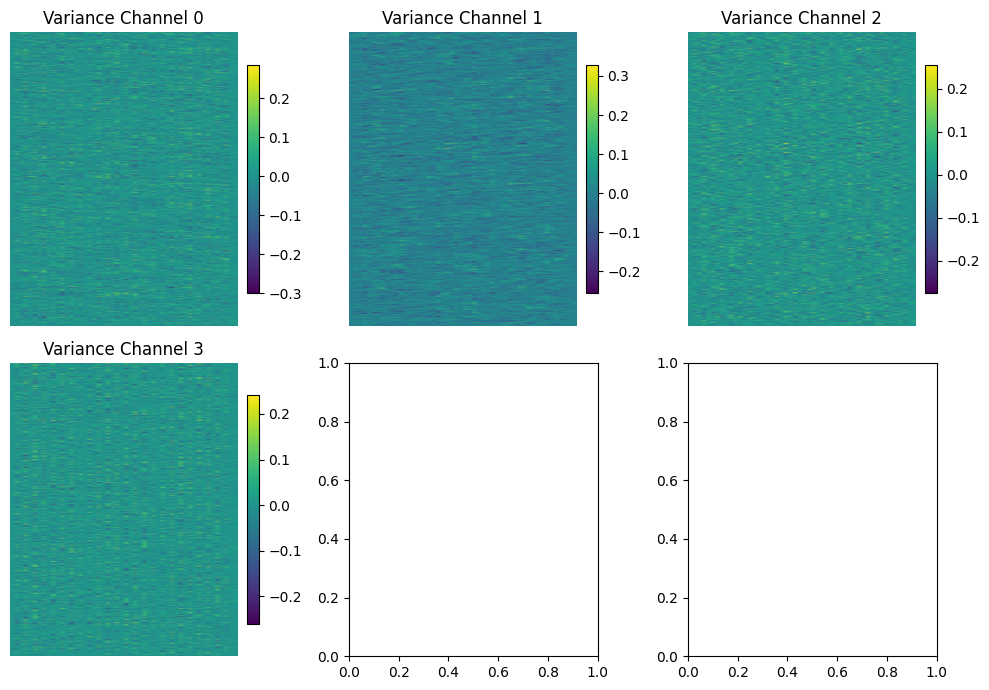

In [51]:
import torch
import matplotlib.pyplot as plt

#Set the VAE to evaluation mode
vae.eval()

#Specify the latent dimension (should match what you used during training)
latent_dim = latent_dim

#Sample a single latent vector from a standard normal distribution and decode it.
with torch.no_grad():
    z1 = torch.randn(1, latent_dim, device=device)  #Sample one latent vector
    z2 = torch.randn(1, latent_dim, device=device)  #Sample one latent vector
    generated1 = vae.decode(z1)
    generated2 = vae.decode(z2)

#Remove the batch dimension and move the tensor to CPU
sample1 = generated1.squeeze(0).cpu()
sample2 = generated2.squeeze(0).cpu()
sample1_np = sample1.numpy()
sample2_np = sample2.numpy()

#Plotting
fig, axs = plt.subplots(2, 2, figsize=(10,7))
axs = axs.ravel()
id_num = np.random.randint(10000)

save = 0

for i in range(4):
    im = axs[i].imshow(sample1_np[i], aspect='auto', cmap='viridis')
    axs[i].set_title(f'Generated Channel {i}')
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

if save:
    fig.savefig(f'Image/GeneratedChannelsv{id_num}.png', dpi=300, bbox_inches='tight')
    
fig2, axs2 = plt.subplots(2, 3, figsize=(10,7))
axs2 = axs2.ravel()

for i in range(4):
    im = axs2[i].imshow(Database_channel_standardized[np.random.randint(1000)][i], aspect='auto', cmap='viridis')
    axs2[i].set_title(f'Base Channel {i}')
    axs2[i].axis('off')
    fig2.colorbar(im, ax=axs2[i], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

if save:
    fig.savefig(f'Image/BaseChannel{id_num}.png', dpi=300, bbox_inches='tight')

fig, axs = plt.subplots(2, 3, figsize=(10,7))
axs = axs.ravel()

for i in range(4):
    im = axs[i].imshow((sample1_np[i] - sample2_np[i]), aspect='auto', cmap='viridis')
    axs[i].set_title(f'Variance Channel {i}')
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

if save:
    fig.savefig(f'Image/VarianceChannel{id_num}.png', dpi=300, bbox_inches='tight')


In [ ]:
#Add noise, avg D and V channels
#Subset, do larger on pretraining
#Try on more samples